In [ ]:
"""
Copyright Netherlands eScience Center

Function        : Regression of climatological variable on AMET (ERA-Interim) with whitening
Author          : Yang Liu
Date            : 2018.05.28
Last Update     : 2018.05.29
Description     : The code aims to explore the assotiation between climatological
                  variables with atmospheric meridional energy transport (AMET).
                  The statistical method employed here is linear regression. A
                  number of fields (SST, SLP, Sea ice, geopotential, etc.),
                  corresponding to the preexisting natural modes of variability,
                  will be projected on meridional energy transport. This will enhance
                  our understanding of climate change. Notice that the time series
                  of input data will be whitened (the seasonal cycles are removed).
                  This script will split summer and winter and look at them individually.

Return Value    : Map of correlation
Dependencies    : os, time, numpy, scipy, netCDF4, matplotlib, basemap
variables       : Sea Surface Temperature                       SST
                  Sea Level Pressure                            SLP
                  Sea Ice Concentration                         ci
                  Geopotential                                  gz
                  Atmospheric meridional energy transport       AMET
Caveat!!        : The input data of AMET is from 20 deg north to 90 deg north (Northern Hemisphere).
"""

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import time as tttt
from netCDF4 import Dataset,num2date
import os
import seaborn as sns
import platform
import logging
#import matplotlib
# Generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm

# switch on the seaborn effect
sns.set()

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [23]:
################################   Input zone  ######################################
# specify data path
# AMET
# for the computation of residual AMET ERA-Interim
datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
# target climatological variables
datapath_y = "/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression"
# specify output path for figures
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision/regress_AMET_ERAI_res/SIC'
# the threshold ( index of latitude) of the AMET
# 20N
lat_ERAI_20 = 93
# 30N
lat_ERAI_30 = 80
# 40N
lat_ERAI_40 = 67
# 50N
lat_ERAI_50 = 53
# 60N
lat_ERAI_60 = 40
# 70N
lat_ERAI_70 = 27
# 80N
lat_ERAI_80 = 13
lat_interest = {}
#lat_interest_list = [20,30,40,50,60,70,80]
lat_interest_list = [60]
#lat_interest['ERAI'] = [lat_ERAI_20,lat_ERAI_30,lat_ERAI_40,lat_ERAI_50,lat_ERAI_60,lat_ERAI_70,lat_ERAI_80]
lat_interest['ERAI'] = [lat_ERAI_60]
# the range ( index of latitude) of the projection field
lat_y = 40 # 60 N - 90 N
####################################################################################

In [26]:
# *********************** extract variables ************************* #
dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                   'surface_erai_monthly_regress_1979_2017_radiation.nc'))
dataset_y = Dataset(datapath_y + os.sep + 'surface_ERAI_monthly_regress_1979_2016.nc')
# extract time series from 1979 to 2016
# from 20N - 90N
# 4D fields [year, month, lat, lon]
rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
# calculate total net energy flux at TOA/surface
net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI

year = dataset_ERAI_fields_flux.variables['year'][:-1]
# extract variables from 20N to 90 N
# sea level pressure
SLP = dataset_y.variables['msl'][:,0:lat_y+1,:]
# sea surface temperature
SST = dataset_y.variables['sst'][:,0:lat_y+1,:]
mask_SST = np.ma.getmaskarray(SST[0,:,:])
# sea ice cover
ci = dataset_y.variables['ci'][:,0:lat_y+1,:]
mask_ci = np.ma.getmaskarray(ci[0,:,:])
np.ma.set_fill_value(ci,0)
# longitude
lon = dataset_y.variables['longitude'][:]
# latitude
lat = dataset_y.variables['latitude'][0:lat_y+1]
# time (number of months)
time = dataset_y.variables['time'][:]

latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
lat_AMET = latitude_fields_ERAI
# area weighted surface flux
net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
#size of the grid box
dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                        360) / len(longitude_fields_ERAI)
dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
for i in np.arange(len(latitude_fields_ERAI)):
    # change the unit to terawatt
    net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
    net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12

In [28]:
print ('Compute AMET as the residuals of net flux at TOA & surface.')
# take the zonal mean of flux
net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
# AMET as the residual of net flux at TOA & surface
AMET = np.zeros(net_flux_surf_ERAI_int.shape)
for i in np.arange(len(latitude_fields_ERAI)-1):
    AMET[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                             np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
print (AMET.shape)

Compute AMET as the residuals of net flux at TOA & surface.
(38, 12, 241)


In [29]:
# *************************** whitening ***************************** #
# remove the seasonal cycling of target climatology for regression
# These climitology data comes from ERA-Interim surface level
month_ind = np.arange(12)
# remove climatology for Sea Level Pressure
SLP_seasonal_mean = np.zeros((12,lat_y+1,len(lon))) # from 20N - 90N
SLP_white = np.zeros(SLP.shape,dtype=float)
for i in month_ind:
    # calculate the monthly mean (seasonal cycling)
    SLP_seasonal_mean[i,:,:] = np.mean(SLP[i::12,:,:],axis=0)
    # remove seasonal mean
    SLP_white[i::12,:,:] = SLP[i::12,:,:] - SLP_seasonal_mean[i,:,:]

# remove climatology for Sea Surface Temperature
SST_seasonal_mean = np.zeros((12,lat_y+1,len(lon))) # from 20N - 90N
SST_white = np.zeros(SST.shape,dtype=float)
for i in month_ind:
    # calculate the monthly mean (seasonal cycling)
    SST_seasonal_mean[i,:,:] = np.mean(SST[i::12,:,:],axis=0)
    # remove seasonal mean
    SST_white[i::12,:,:] = SST[i::12,:,:] - SST_seasonal_mean[i,:,:]

# remove climatology for Sea Ice Concentration
ci_seasonal_mean = np.zeros((12,lat_y+1,len(lon))) # from 20N - 90N
ci_white = np.zeros(ci.shape)
for i in month_ind:
    # calculate the monthly mean (seasonal cycling)
    ci_seasonal_mean[i,:,:] = np.mean(ci[i::12,:,:].filled(),axis=0)
    # remove seasonal mean
    ci_white[i::12,:,:] = ci[i::12,:,:].filled() - ci_seasonal_mean[i,:,:]

# remove the seasonal cycling of AMET at 60N
# dimension of AMET[year,month]
AMET_seansonal_cycle = np.mean(AMET,axis=0)
AMET_white = np.zeros(AMET.shape,dtype=float)
for i in month_ind:
    AMET_white[:,i,:] = AMET[:,i,:] - AMET_seansonal_cycle[i,:]
#'*******************************************************************'
#'*********************** prepare variables *************************'
#'*******************************************************************'
# take the time series of E
AMET_series = AMET.reshape(len(year)*len(month_ind),len(lat_AMET))
AMET_white_series = AMET_white.reshape(len(year)*len(month_ind),len(lat_AMET))
#'*******************************************************************'
#'***********************  summer / winter  *************************'
#'*******************************************************************'
# Summer and winter only
# summer refers to June(5), July(6), August(7)
# winter refers to Dec(11), Jan(0), Feb(1)
#AMET
AMET_white_series_summer = np.zeros((len(year)*len(month_ind)//4,len(lat_AMET)),dtype=float)
AMET_white_series_winter = np.zeros((len(year)*len(month_ind)//4,len(lat_AMET)),dtype=float)

AMET_white_series_summer[0::3,:] = AMET_white_series[5::12,:] #June
AMET_white_series_summer[1::3,:] = AMET_white_series[6::12,:] #July
AMET_white_series_summer[2::3,:] = AMET_white_series[7::12,:] #August
AMET_white_series_winter[2::3,:] = AMET_white_series[11::12,:] # December
AMET_white_series_winter[0::3,:] = AMET_white_series[0::12,:] # Jan
AMET_white_series_winter[1::3,:] = AMET_white_series[1::12,:] # Feb

# SIC
ci_white_summer = np.zeros((len(time)//4,lat_y+1,len(lon)),dtype=float)
ci_white_winter = np.zeros((len(time)//4,lat_y+1,len(lon)),dtype=float)

ci_white_summer[0::3,:,:] = ci_white[5::12,:,:] #June
ci_white_summer[1::3,:,:] = ci_white[6::12,:,:] #June
ci_white_summer[2::3,:,:] = ci_white[7::12,:,:] #June
ci_white_winter[2::3,:,:] = ci_white[11::12,:,:] #June
ci_white_winter[0::3,:,:] = ci_white[0::12,:,:] #June
ci_white_winter[1::3,:,:] = ci_white[1::12,:,:] #June
# ***************************  Detrend  ***************************** #
####################################################
######      detrend - polynomial fitting      ######
####################################################
# summer
poly_fit = np.zeros(ci_white_summer.shape,dtype=float)
for i in np.arange(len(lat)):
    for j in np.arange(len(lon)):
        polynomial = np.polyfit(np.arange(len(time)//4), ci_white_summer[:,i,j], 3)
        poly = np.poly1d(polynomial)
        poly_fit[:,i,j] = poly(np.arange(len(time)//4))

ci_white_detrend_summer = np.zeros(ci_white_summer.shape,dtype=float)
ci_white_detrend_summer = ci_white_summer - poly_fit
# winter
poly_fit = np.zeros(ci_white_winter.shape,dtype=float)
for i in np.arange(len(lat)):
    for j in np.arange(len(lon)):
        polynomial = np.polyfit(np.arange(len(time)//4), ci_white_winter[:,i,j], 3)
        poly = np.poly1d(polynomial)
        poly_fit[:,i,j] = poly(np.arange(len(time)//4))

ci_white_detrend_winter = np.zeros(ci_white_winter.shape,dtype=float)
ci_white_detrend_winter = ci_white_winter - poly_fit

In [30]:
# ********************** Running mean/sum *************************** #
# running mean is calculated on time series
# define the running window for the running mean
window = 3 # in month = 1 year
#window = 9 # in month = 3 year
#window = 15 # in month = 5 year
# calculate the running mean of AMET summer/winter
AMET_white_series_summer_running_mean = np.zeros((len(year)*len(month_ind)//4-window+1,len(lat_AMET)),dtype=float)
for i in np.arange(len(year)*len(month_ind)//4-window+1):
    AMET_white_series_summer_running_mean[i,:] = np.mean(AMET_white_series_summer[i:i+window,:],0)

AMET_white_series_winter_running_mean = np.zeros((len(year)*len(month_ind)//4-window+1,len(lat_AMET)),dtype=float)
for i in np.arange(len(year)*len(month_ind)//4-window+1):
    AMET_white_series_winter_running_mean[i,:] = np.mean(AMET_white_series_winter[i:i+window,:],0)

ci_white_detrend_summer_running_mean = np.zeros((len(year)*len(month_ind)//4-window+1,lat_y+1,len(lon)),dtype=float)
for i in np.arange(len(year)*len(month_ind)//4-window+1):
    ci_white_detrend_summer_running_mean[i,:] = np.mean(ci_white_detrend_summer[i:i+window,:],0)

ci_white_detrend_winter_running_mean = np.zeros((len(year)*len(month_ind)//4-window+1,lat_y+1,len(lon)),dtype=float)
for i in np.arange(len(year)*len(month_ind)//4-window+1):
    ci_white_detrend_winter_running_mean[i,:] = np.mean(ci_white_detrend_winter[i:i+window,:],0)

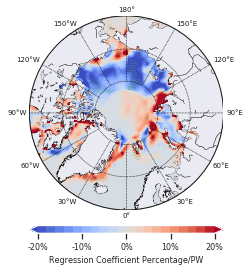

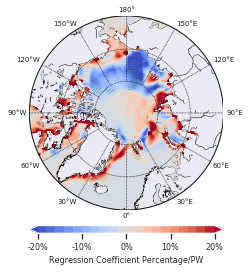

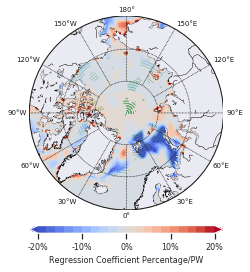

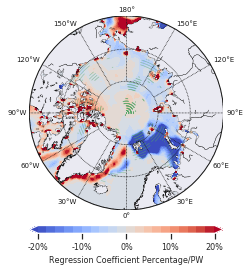

In [31]:
# ************************** regression ***************************** #
# calculate the standard deviation of AMET anomaly
AMET_white_std = np.std(AMET_white_series)

# all the regression are taken on anomalies of variables
# this is because the seasonal cycles are always too strong

# create an array to store the correlation coefficient
slope = np.zeros((lat_y+1,len(lon)),dtype = float)
r_value = np.zeros((lat_y+1,len(lon)),dtype = float)
p_value = np.zeros((lat_y+1,len(lon)),dtype = float)
#######################################################################################################
# Since running mean will make the points more correlated with each other
# Apparently the T-test based on running mean time series will overestime the level of significance
# However, it is difficult to determine the degress of freedom as the points are actually correlated
# with space and time domain. As a compromise, we use the T-test results from the regression of SIC on
# original time series.
#######################################################################################################
p_value_original = np.zeros((lat_y+1,len(lon)),dtype = float)

for c in np.arange(len(lat_interest_list)):
    # linear regress Sea Ice Concentration on AMET (anomalies) in different seasons
    # plot correlation coefficient
    for i in np.arange(lat_y+1):
        for j in np.arange(len(lon)):
            # return value: slope, intercept, r_value, p_value, stderr
            slope[i,j],_,r_value[i,j],p_value_original[i,j],_ = stats.linregress(AMET_white_series_summer[:,lat_interest['ERAI'][c]],ci_white_detrend_summer[:,i,j])
    p_value_original[mask_ci==True] = 1.0
    # plot regression coefficient
    fig5 = plt.figure()
    # setup north polar stereographic basemap
    m = Basemap(projection='npstere',boundinglat=60,round=True,lon_0=0,resolution='l')
    # draw coastlines
    m.drawcoastlines(linewidth=0.25)
    # draw parallels and meridians
    m.drawparallels(np.arange(60,81,10),fontsize = 7,linewidth=0.75)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],fontsize = 7,linewidth=0.75)
    # x,y coordinate - lon, lat
    xx, yy = np.meshgrid(lon,lat[0:lat_y+1])
    XX, YY = m(xx, yy)
    # define color range for the contourf
    color = np.linspace(-0.20,0.20,21)
    # !!!!!take care about the coordinate of contourf(Longitude, Latitude, data(Lat,Lon))
    cs = m.contourf(XX,YY,np.ma.masked_where(mask_ci[0:lat_y+1,:],slope),color,cmap='coolwarm',extend='both')
    # add color bar
    cbar = m.colorbar(cs,location="bottom",size='4%',pad="8%",format='%.2f',ticks=[-0.20,-0.10,0,0.10,0.20])
    cbar.ax.tick_params(labelsize=8)
    #cbar.set_ticks(np.arange(0,6))
    cbar_labels = ['-20%','-10%','0%','10%','20%']
    cbar.ax.set_xticklabels(cbar_labels)
    cbar.set_label('Regression Coefficient Percentage/PW',fontsize = 8)
    i, j = np.where(p_value_original<=0.05)
    # get the coordinate on the map (lon,lat) and plot scatter dots
    m.scatter(XX[i,j],YY[i,j],2.2,marker='.',color='g',alpha=0.6, edgecolor='none') # alpha bleding factor with map
    #plt.title('Regression of SIC Anomaly on AMET Anomaly in summer across %dN' % (lat_interest_list[c]),fontsize = 9, y=1.05)
    plt.show()
    fig5.savefig(output_path + os.sep + "Regression_AMET_Ice_ERAI_summer_white_%dN_regression_coef.jpeg" % (lat_interest_list[c]),dpi=400)

    for i in np.arange(lat_y+1):
        for j in np.arange(len(lon)):
            # return value: slope, intercept, r_value, p_value, stderr
            slope[i,j],_,r_value[i,j],p_value[i,j],_ = stats.linregress(AMET_white_series_summer_running_mean[:,lat_interest['ERAI'][c]],ci_white_detrend_summer_running_mean[:,i,j])
    # plot regression coefficient
    fig6 = plt.figure()
    # setup north polar stereographic basemap
    m = Basemap(projection='npstere',boundinglat=60,round=True,lon_0=0,resolution='l')
    # draw coastlines
    m.drawcoastlines(linewidth=0.25)
    # draw parallels and meridians
    m.drawparallels(np.arange(60,81,10),fontsize = 7,linewidth=0.75)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],fontsize = 7,linewidth=0.75)
    # x,y coordinate - lon, lat
    xx, yy = np.meshgrid(lon,lat[0:lat_y+1])
    XX, YY = m(xx, yy)
    # define color range for the contourf
    color = np.linspace(-0.20,0.20,21)
    # !!!!!take care about the coordinate of contourf(Longitude, Latitude, data(Lat,Lon))
    cs = m.contourf(XX,YY,np.ma.masked_where(mask_ci[0:lat_y+1,:],slope),color,cmap='coolwarm',extend='both')
    # add color bar
    cbar = m.colorbar(cs,location="bottom",size='4%',pad="8%",format='%.2f',ticks=[-0.20,-0.10,0,0.10,0.20])
    cbar.ax.tick_params(labelsize=8)
    #cbar.set_ticks(np.arange(0,6)
    cbar_labels = ['-20%','-10%','0%','10%','20%']
    cbar.ax.set_xticklabels(cbar_labels)
    cbar.set_label('Regression Coefficient Percentage/PW',fontsize = 8)
    i, j = np.where(p_value_original<=0.05)
    # get the coordinate on the map (lon,lat) and plot scatter dots
    m.scatter(XX[i,j],YY[i,j],2.2,marker='.',color='g',alpha=0.6, edgecolor='none') # alpha bleding factor with map
    #plt.title('Regression of Detrend SIC Anomaly on AMET Anomaly in summer across %dN with a running mean of %d years' % (lat_interest_list[c],window/3),fontsize = 9, y=1.05)
    plt.show()
    fig6.savefig(output_path + os.sep + "Regression_AMET_Ice_ERAI_summer_white_%dN_running_mean_%dy_regression_coef.jpeg" % (lat_interest_list[c],window/3),dpi=400)
    #fig6.savefig(output_path + os.sep + 'SIC' + os.sep + 'Season' + os.sep + 'Annual'+ os.sep + "Regression_AMET_Ice_ERAI_summer_white_%dN_running_mean_%dy_regression_coef.jpeg" % (lat_interest_list[c],window/3),dpi=400)

    # plot correlation coefficient
    for i in np.arange(lat_y+1):
        for j in np.arange(len(lon)):
            # return value: slope, intercept, r_value, p_value, stderr
            slope[i,j],_,r_value[i,j],p_value_original[i,j],_ = stats.linregress(AMET_white_series_winter[:,lat_interest['ERAI'][c]],ci_white_detrend_winter[:,i,j])
    p_value_original[mask_ci==True] = 1.0
    # plot regression coefficient
    fig7 = plt.figure()
    # setup north polar stereographic basemap
    m = Basemap(projection='npstere',boundinglat=60,round=True,lon_0=0,resolution='l')
    # draw coastlines
    m.drawcoastlines(linewidth=0.25)
    # draw parallels and meridians
    m.drawparallels(np.arange(60,81,10),fontsize = 7,linewidth=0.75)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],fontsize = 7,linewidth=0.75)
    # x,y coordinate - lon, lat
    xx, yy = np.meshgrid(lon,lat[0:lat_y+1])
    XX, YY = m(xx, yy)
    # define color range for the contourf
    color = np.linspace(-0.20,0.20,21)
    # !!!!!take care about the coordinate of contourf(Longitude, Latitude, data(Lat,Lon))
    cs = m.contourf(XX,YY,np.ma.masked_where(mask_ci[0:lat_y+1,:],slope),color,cmap='coolwarm',extend='both')
    # add color bar
    cbar = m.colorbar(cs,location="bottom",size='4%',pad="8%",format='%.2f',ticks=[-0.20,-0.10,0,0.10,0.20])
    cbar.ax.tick_params(labelsize=8)
    #cbar.set_ticks(np.arange(0,6))
    cbar_labels = ['-20%','-10%','0%','10%','20%']
    cbar.ax.set_xticklabels(cbar_labels)
    cbar.set_label('Regression Coefficient Percentage/PW',fontsize = 8)
    i, j = np.where(p_value_original<=0.05)
    # get the coordinate on the map (lon,lat) and plot scatter dots
    m.scatter(XX[i,j],YY[i,j],2.2,marker='.',color='g',alpha=0.6, edgecolor='none') # alpha bleding factor with map
    #plt.title('Regression of SIC Anomaly on AMET Anomaly in winter across %dN' % (lat_interest_list[c]),fontsize = 9, y=1.05)
    plt.show()
    fig7.savefig(output_path + os.sep + "Regression_AMET_Ice_ERAI_winter_white_%dN_regression_coef.jpeg" % (lat_interest_list[c]),dpi=400)

    for i in np.arange(lat_y+1):
        for j in np.arange(len(lon)):
            # return value: slope, intercept, r_value, p_value, stderr
            slope[i,j],_,r_value[i,j],p_value[i,j],_ = stats.linregress(AMET_white_series_winter_running_mean[:,lat_interest['ERAI'][c]],ci_white_detrend_winter_running_mean[:,i,j])
    # plot regression coefficient
    fig8 = plt.figure()
    # setup north polar stereographic basemap
    m = Basemap(projection='npstere',boundinglat=60,round=True,lon_0=0,resolution='l')
    # draw coastlines
    m.drawcoastlines(linewidth=0.25)
    # draw parallels and meridians
    m.drawparallels(np.arange(60,81,10),fontsize = 7,linewidth=0.75)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],fontsize = 7,linewidth=0.75)
    # x,y coordinate - lon, lat
    xx, yy = np.meshgrid(lon,lat[0:lat_y+1])
    XX, YY = m(xx, yy)
    # define color range for the contourf
    color = np.linspace(-0.20,0.20,21)
    # !!!!!take care about the coordinate of contourf(Longitude, Latitude, data(Lat,Lon))
    cs = m.contourf(XX,YY,np.ma.masked_where(mask_ci[0:lat_y+1,:],slope),color,cmap='coolwarm',extend='both')
    # add color bar
    cbar = m.colorbar(cs,location="bottom",size='4%',pad="8%",format='%.2f',ticks=[-0.20,-0.10,0,0.10,0.20])
    cbar.ax.tick_params(labelsize=8)
    #cbar.set_ticks(np.arange(0,6)
    cbar_labels = ['-20%','-10%','0%','10%','20%']
    cbar.ax.set_xticklabels(cbar_labels)
    cbar.set_label('Regression Coefficient Percentage/PW',fontsize = 8)
    i, j = np.where(p_value_original<=0.05)
    # get the coordinate on the map (lon,lat) and plot scatter dots
    m.scatter(XX[i,j],YY[i,j],2.2,marker='.',color='g',alpha=0.6, edgecolor='none') # alpha bleding factor with map
    #plt.title('Regression of Detrend SIC Anomaly on AMET Anomaly in winter across %dN with a running mean of %d years' % (lat_interest_list[c],window/3),fontsize = 9, y=1.05)
    plt.show()
    fig8.savefig(output_path + os.sep + "Regression_AMET_Ice_ERAI_winter_white_%dN_running_mean_%dy_regression_coef.jpeg" % (lat_interest_list[c],window/3),dpi=400)
    #fig8.savefig(output_path + os.sep + 'SIC' + os.sep + 'Season' + os.sep + 'Annual'+ os.sep + "Regression_AMET_Ice_ERAI_winter_white_%dN_running_mean_%dy_regression_coef.jpeg" % (lat_interest_list[c],window/3),dpi=400)